In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all words in words.txt
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32084


In [3]:
# building vocab of chars and mapping from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Dataset Creation

In [4]:
# Create the dataset
block_size = 3
X, Y =[], []
for w in words:
    
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, Y.shape

(torch.Size([228522, 3]), torch.Size([228522]))

## Building embedding lookup table C
* Earlier we had 27 chars with their representation in 27 dim
* We will reduce the dim to 2 i.e 27 chars with representation of 2dim

In [6]:
C = torch.randn((27, 2))
C[5]

tensor([-0.3960,  0.2638])

In [7]:
F.one_hot(torch.tensor(5), num_classes = 27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [8]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([-0.3960,  0.2638])

In [9]:
X.shape, Y.shape

(torch.Size([228522, 3]), torch.Size([228522]))

In [10]:
emb = C[X]
print(emb.shape)   # input shape
#emb

torch.Size([228522, 3, 2])


## Hidden Layer implementation W1
* Need to transform input 32, 3, 2 into something 32,6 so that multiplication is valid

In [11]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [12]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

torch.Size([228522, 6])

In [13]:
emb[:,1,:].shape

torch.Size([228522, 2])

In [14]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228522, 6])

In [15]:
#emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

### Hidden layer h

In [16]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228522, 100])

In [17]:
h

tensor([[-0.9882,  0.9991,  0.4543,  ...,  0.9999, -0.9753,  1.0000],
        [-0.9840, -0.4678,  1.0000,  ...,  0.9980, -0.3181,  0.8698],
        [-0.1615, -0.9126,  0.9669,  ...,  0.8804, -0.9906, -0.3194],
        ...,
        [-0.7056, -0.9290,  0.9979,  ..., -1.0000, -0.7590, -0.9995],
        [ 0.5023, -0.9042, -0.4263,  ...,  0.9581, -0.9998, -0.9999],
        [-0.9454, -0.7046, -0.9994,  ..., -0.9914,  0.2792,  0.8098]])

## Output Layer

In [18]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [19]:
logits = h @ W2+b2
logits.shape

torch.Size([228522, 27])

In [20]:
# Softmax
counts = logits.exp()
probs = counts / counts.sum(1, keepdims = True)
#probs[0].sum()

In [21]:
Y.shape

torch.Size([228522])

In [22]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [23]:
#probs[torch.arange(32), Y]

In [24]:
# # Negative log likelihood
# loss = -probs[torch.arange(32), Y].log().mean()
# loss

## SUMMARISING

In [25]:
X.shape , Y.shape

(torch.Size([228522, 3]), torch.Size([228522]))

In [26]:
g = torch.Generator().manual_seed(2147483647)
#----Embedding layer-------
C = torch.randn((27,2), generator = g)

#----Hidden Layer -------
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)

# ----Output Layer--------
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [27]:
print(f"Number of parameters of this model : {sum(p.nelement() for p in parameters)}")

Number of parameters of this model : 3481


In [28]:
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1+b1) #(32, 100)
logits = h @ W2+b2
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdims = True)
# loss = -probs[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(19.5028)

In [29]:
F.cross_entropy(logits, Y)

tensor(19.5028)

## Training
#### Now we want to minimise this particular loss

In [30]:
for p in parameters : 
    p.requires_grad = True

In [31]:
# for _ in range(10): 
#     # Forward Pass
#     emb = C[X] 
#     h = torch.tanh(emb.view(-1, 6) @ W1+b1) #(32, 100)
#     logits = h @ W2+b2
#     loss = F.cross_entropy(logits, Y)
#     print(f'Loss : {loss.item()}')

#     # Backward Pass
#     for p in parameters:
#         p.grad = None
#     loss.backward()

#     # Update
#     for p in parameters:
#         p.data += -0.1 * p.grad

It takes a long time to calculate loss as we are going throug all. We should go through batches and calculate loss

### Mini batch training 

In [32]:
torch.randint(0, X.shape[0], (32,)) # this is the random indexes of our dataset

tensor([ 87729, 134121, 124317,  87030, 124189, 112373,  69834, 120658, 219406,
        108622, 157461, 225049,  86645,   3000,  56463,  18567,  68806,  95118,
         24976, 166083, 109837, 182137, 154380, 221744, 181763, 125325,  11840,
         67156, 220454, 125748,  74735,  22351])

In [33]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponents
lrs = 10**lre
#lrs # candidates for learning rates

In [34]:
lri = []
lossi = []
for i in range(1000): 
    
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))
    # Forward Pass
    emb = C[X[ix]]  # 32,3,2
    h = torch.tanh(emb.view(-1, 6) @ W1+b1) #(32, 100)
    logits = h @ W2+b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(f'Loss : {loss.item()}')

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
    
#print(f'Loss : {loss.item()}')

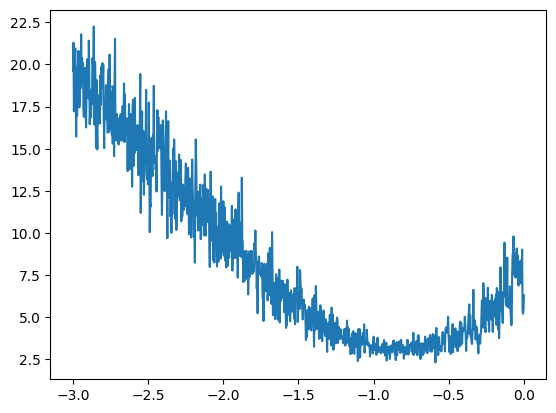

In [35]:
plt.plot(lri, lossi)

In [36]:
lri = []
lossi = []
for i in range(9000): 
    
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))
    # Forward Pass
    emb = C[X[ix]]  # 32,3,2
    h = torch.tanh(emb.view(-1, 6) @ W1+b1) #(32, 100)
    logits = h @ W2+b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(f'Loss : {loss.item()}')

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    #lri.append(lre[i])
    #lossi.append(loss.item())
    
#print(f'Loss : {loss.item()}')

### best lr exponent comes out to be -1 that is lr = 0.1

In [37]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1+b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5165, grad_fn=<NllLossBackward0>)

### Best loss till now than bigram 2.31 < 2.45

## Train test and val split

In [38]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182603, 3]) torch.Size([182603])
torch.Size([23085, 3]) torch.Size([23085])
torch.Size([22834, 3]) torch.Size([22834])


In [39]:
len(words), n1, n2

(32084, 25667, 28875)

In [40]:
Xtr.shape, Ytr.shape

(torch.Size([182603, 3]), torch.Size([182603]))

In [41]:
g = torch.Generator().manual_seed(2147483647)
#----Embedding layer-------
C = torch.randn((27,2), generator = g)

#----Hidden Layer -------
W1 = torch.randn((6, 300), generator = g)
b1 = torch.randn(300, generator = g)

# ----Output Layer--------
W2 = torch.randn((300,27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]
print(f"Number of parameters of this model : {sum(p.nelement() for p in parameters)}")

for p in parameters : 
    p.requires_grad = True

Number of parameters of this model : 10281


In [42]:
lri = []
lossi = []
stepi = []

In [63]:
for i in range(20000): 
    
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # Forward Pass
    emb = C[Xtr[ix]]  # 32,3,2
    h = torch.tanh(emb.view(-1, 6) @ W1+b1) #(32, 100)
    logits = h @ W2+b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f'Loss : {loss.item()}')

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
    
print(f'Loss : {loss.item()}')

Loss : 2.309565305709839


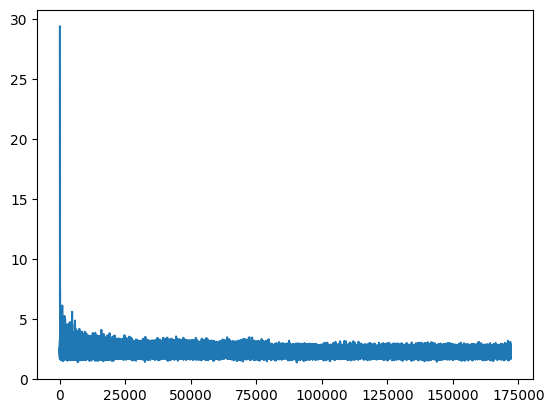

In [64]:
plt.plot(stepi, lossi)

### Evaluating the loss through the Val set
Not ovefitting but underfitting

In [65]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1+b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2230, grad_fn=<NllLossBackward0>)

In [66]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1+b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2054, grad_fn=<NllLossBackward0>)

### The val loss does not increase much after doing learning rate decay and training for many times. May be the bottle neck now is the embedding vectors being two dimensional

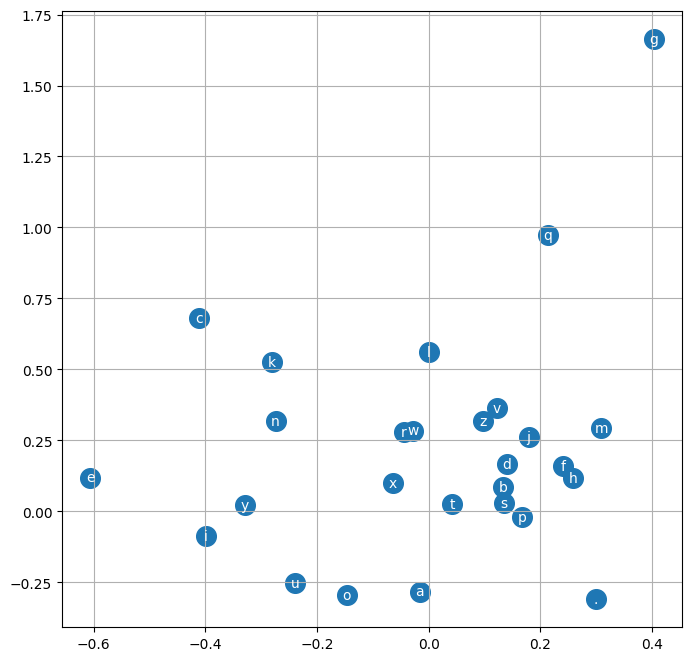

In [47]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

### After training for more times, changing number of steps

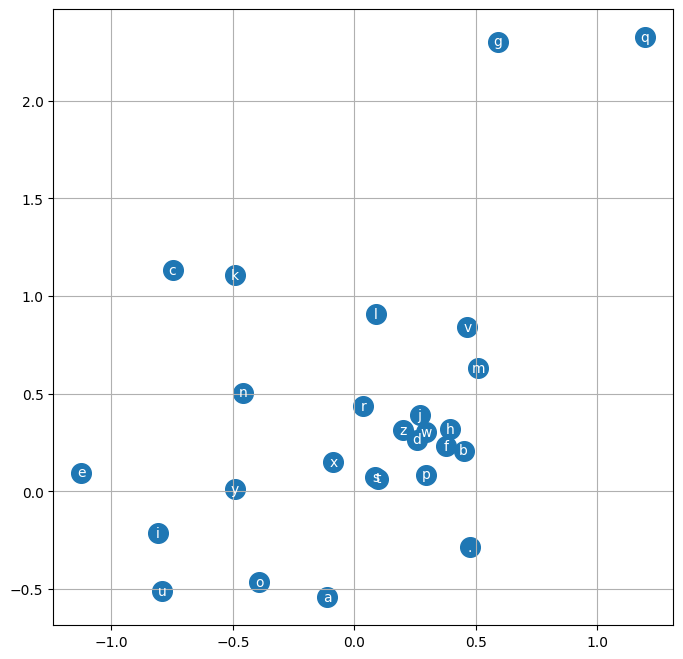

In [67]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

### After increasing the number of dimensions of the embedding

In [76]:
g = torch.Generator().manual_seed(2147483647)
#----Embedding layer-------
C = torch.randn((27,10), generator = g)

#----Hidden Layer -------
W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)

# ----Output Layer--------
W2 = torch.randn((200,27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]
print(f"Number of parameters of this model : {sum(p.nelement() for p in parameters)}")

for p in parameters : 
    p.requires_grad = True

Number of parameters of this model : 11897


In [77]:
lri = []
lossi = []
stepi = []

In [78]:
for i in range(200000): 
    
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # Forward Pass
    emb = C[Xtr[ix]]  # 32,3,2
    h = torch.tanh(emb.view(-1, 30) @ W1+b1) #(32, 100)
    logits = h @ W2+b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f'Loss : {loss.item()}')

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
print(f'Loss : {loss.item()}')

Loss : 1.9365967512130737


In [79]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1+b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1604, grad_fn=<NllLossBackward0>)

In [80]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1+b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1178, grad_fn=<NllLossBackward0>)

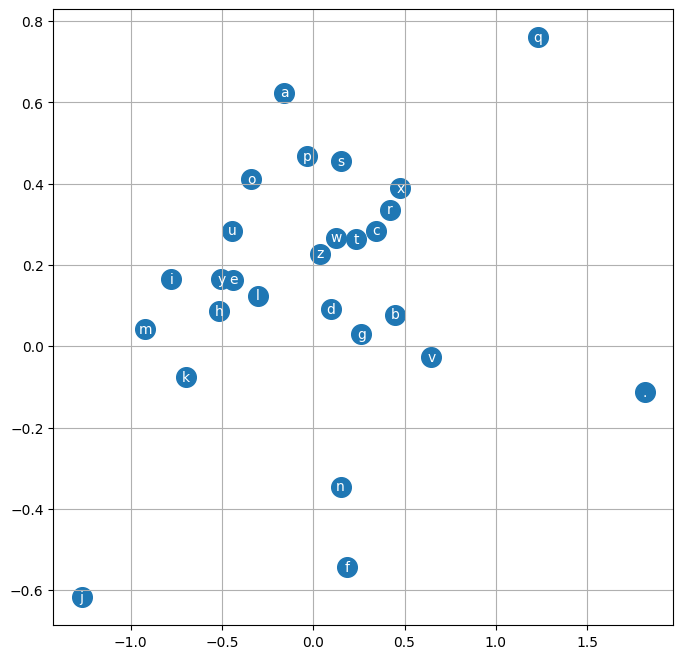

In [81]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
##